<a href="https://colab.research.google.com/github/stelios191/Image-Classification/blob/main/MNIST_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep network for image classification

#DATASET: MNIST

**check for GPU.**

In [ ]:
!nvidia-smi

Mon Apr 29 19:40:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**1.Download packages**

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

**2. Libraries**

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os
from sklearn import metrics
from torchvision.models import googlenet
from torchsummary import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

**3.Dataset**

In [ ]:
train_data = torchvision.datasets.MNIST(root = ".", train=True, download=True, transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,), (0.2023,)) ]))
test_data = torchvision.datasets.MNIST(root = ".", train=False, download=True, transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,), (0.2023,)) ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 5076410.58it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 134022.20it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1091087.07it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20617455.38it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



**3.1 Dataset loader**

In [ ]:
def data_loaders(train_data,test_data,batch_size):
    #Data loaders with dynamic batch size
    train_loader =DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader =DataLoader(test_data,batch_size=batch_size,shuffle=False)
    print(f"train_loader length:{len(train_loader)}")
    print(f"test_loader length:{len(test_loader)}")
    return train_loader,test_loader

**4.Vizualize Data**

In [ ]:
image,label =train_data[0]
names =train_data.classes
print(f"Image size:{image.shape}")
print(f"Class names:{names}")
print(f"Train data length:{len(train_data.data)}")
print(f"Test data length:{len(test_data.data)}")

Image size:torch.Size([1, 32, 32])
Class names:['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Train data length:60000
Test data length:10000


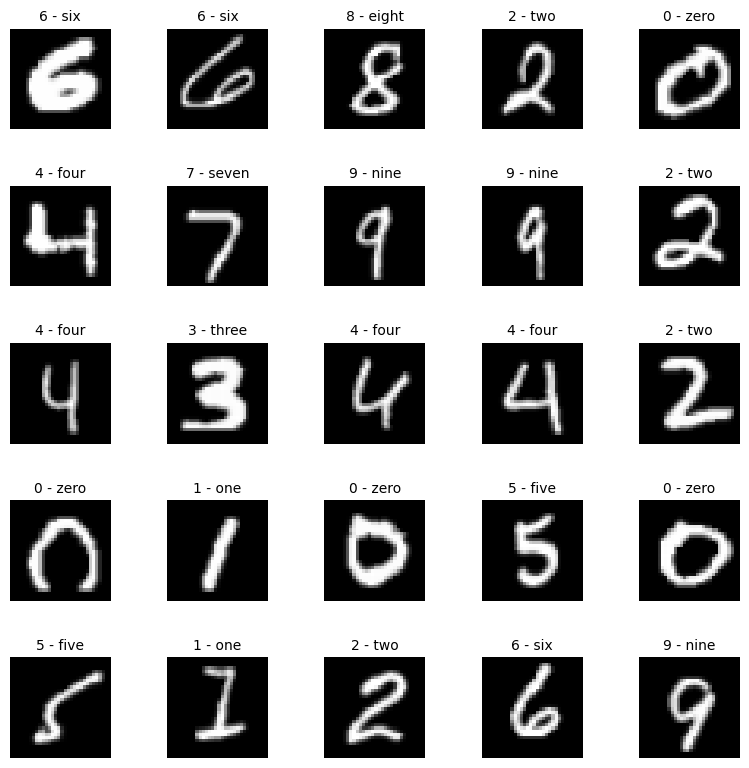

In [ ]:
torch.manual_seed(42)
grid_size = (5, 5)
fig_size = (8, 8)
#Create a figure with specified size
fig, axarr = plt.subplots(*grid_size, figsize=fig_size)
#spacing between subplots
fig.tight_layout(pad=1.0)
for ax in axarr.ravel():
    #Select a random image and its corresponding label
    index = torch.randint(len(train_data), (1,)).item()
    image, label = train_data[index]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(names[label], fontsize=10)
    ax.axis('off')
plt.show()

#Helper Functions

In [ ]:
def compute_accuracy(true_labels,predicted_labels):
    #Compute the accuracy of predictions
    correct_predictions =torch.eq(true_labels,predicted_labels).sum().item()
    accuracy =(correct_predictions / len(true_labels)) * 100
    return accuracy

def train_and_test(model,train_loader,test_loader,criterion,optimizer,device,num_epochs:int):
    model.to(device)
    train_accuracies =[]
    train_losses =[]
    test_accuracies =[]
    test_losses =[]
    training_time =0
    for epoch in range(num_epochs):
        #Start time for the epoch
        start_time =time.time()
        #Training
        model.train()
        train_loss,train_accuracy =0, 0
        for inputs,targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs,targets =inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs =model(inputs)
            loss =criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            train_loss +=loss.item() * inputs.size(0)
            train_accuracy +=compute_accuracy(targets, outputs.argmax(dim=1))
        epoch_train_loss =train_loss / len(train_loader.dataset)
        epoch_train_accuracy =train_accuracy / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        #Testing
        model.eval()
        test_loss, test_accuracy =0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader,desc="Testing"):
                inputs, targets =inputs.to(device),targets.to(device)
                outputs =model(inputs)
                loss =criterion(outputs, targets)
                test_loss +=loss.item() * inputs.size(0)
                test_accuracy +=compute_accuracy(targets, outputs.argmax(dim=1))
        epoch_test_loss =test_loss / len(test_loader.dataset)
        epoch_test_accuracy =test_accuracy / len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)
        # Timing and printing
        epoch_duration =time.time() - start_time
        training_time +=epoch_duration
        print(f'Epoch {epoch+1}: Train Loss:{epoch_train_loss:.4f},Train Accuracy:{epoch_train_accuracy:.2f}%, '
              f'Test Loss:{epoch_test_loss:.4f},Test Accuracy:{epoch_test_accuracy:.2f}%, '
              f'Duration:{epoch_duration:.2f}s')
    print(f"Total training time:{training_time:.2f}s")
    return train_accuracies,train_losses,test_accuracies,test_losses,training_time

def plot_loss(train_losses,test_losses):
    #Plot training and testing losses over epochs
    plt.figure(figsize=(10,6))
    epochs = range(1,len(train_losses) + 1)
    plt.plot(epochs,train_losses,'o-',label='Train Loss')
    plt.plot(epochs,test_losses,'o-',label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies,test_accuracies):
    #Plot training and testing accuracies over epochs
    plt.figure(figsize=(10, 6))
    epochs = range(1,len(train_accuracies) + 1)
    plt.plot(epochs,train_accuracies, 'o-',label='Train Accuracy')
    plt.plot(epochs,test_accuracies,'o-',label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualise_predictions(model,test_loader,device,num_images: int):
    #Visualise random predictions with images showing the true label and the model prediction color coded
    model.eval()
    sample =torch.randperm(len(test_loader.dataset))[:num_images]
    sampler =SubsetRandomSampler(sample)
    random_loader =DataLoader(test_loader.dataset,batch_size=num_images,sampler=sampler)
    images,labels =next(iter(random_loader))
    images,labels =images.to(device), labels.to(device)
    #Compute model outputs
    outputs =model(images)
    #Get the predicted class
    _, preds = torch.max(outputs, 1)
    #The grid size based on the number of images to display
    nrows =int(num_images ** 0.5)
    ncols =(num_images // nrows) + (num_images % nrows > 0)
    plt.figure(figsize=(2 * ncols, 2 * nrows))
    for i in range(num_images):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        true_label =labels[i].item()
        pred_label =preds[i].item()
        title_text =f"True: {true_label}\nPred: {pred_label}"
        title_color ="green" if true_label == pred_label else "red"
        ax.set_title(title_text,color=title_color,fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#ResNet-18

**The model is adapted from PyTorch original implementation [link](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#ResNet18_Weights)**

In [ ]:
class BasicBlock(nn.Module):
    expansion =1
    def __init__(self, in_channels,out_channels,stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 =nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1 =nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 =nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
        self.shortcut =nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride ),
                nn.BatchNorm2d(self.expansion * out_channels))

    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out +=self.shortcut(x)
        out=F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self,block,num_blocks,num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels =64
        self.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =nn.BatchNorm2d(64)
        self.layer1 =self._make_layer(block,64,num_blocks[0],stride=1)
        self.layer2 =self._make_layer(block,128,num_blocks[1],stride=2)
        self.layer3 =self._make_layer(block,256,num_blocks[2],stride=2)
        self.layer4 =self._make_layer(block,512,num_blocks[3],stride=2)
        self.linear =nn.Linear(512 * block.expansion,num_classes)

    def _make_layer(self,block,out_channels,num_blocks,stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels,stride))
            self.in_channels= out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out,(1,1))
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return out

In [ ]:
ResNet_model = ResNet(BasicBlock,[2,2,2,2],num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(ResNet_model.parameters(),lr=0.01,momentum=0.9)
batch_size = 32
train_loader,test_loader =data_loaders(train_data,test_data,batch_size)

train_loader length:1875
test_loader length:313


In [ ]:
print(ResNet_model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut)

In [ ]:
x = torch.randn(10,1,32,32).to(device)
try:
    output = ResNet_model(x)
    print("Output shape:", output.shape)
except Exception as e:
    print("Error", e)

Output shape: torch.Size([10, 10])


In [ ]:
summary(ResNet_model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             576
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

**Train**

Testing: 100%|██████████| 313/313 [00:05<00:00, 57.49it/s]


Epoch 1: Train Loss:0.1038,Train Accuracy:96.78%, Test Loss:0.0307,Test Accuracy:98.99%, Duration:88.68s


Testing: 100%|██████████| 313/313 [00:05<00:00, 56.69it/s]


Epoch 2: Train Loss:0.0328,Train Accuracy:98.96%, Test Loss:0.0216,Test Accuracy:99.28%, Duration:83.39s
Total training time:172.07s


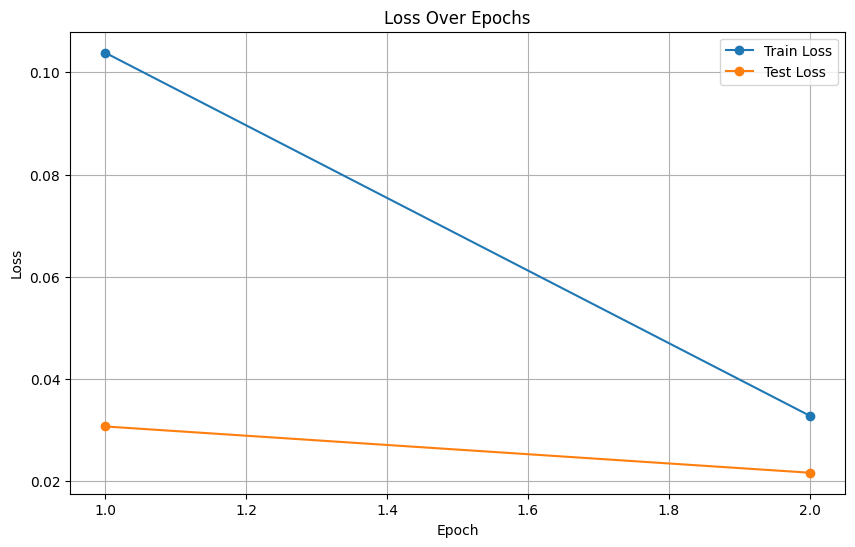

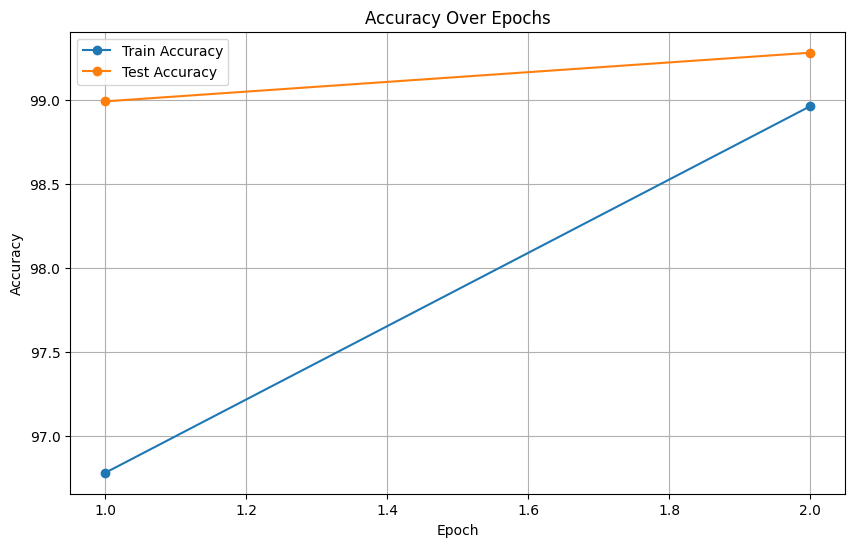

In [ ]:
train_accuracies,train_losses,test_accuracies,test_losses,total_train_time =train_and_test(ResNet_model,train_loader,test_loader,criterion,optimizer,device,num_epochs=2)
plot_loss(train_losses,test_losses)
plot_accuracy(train_accuracies,test_accuracies)

#**Evaluation**

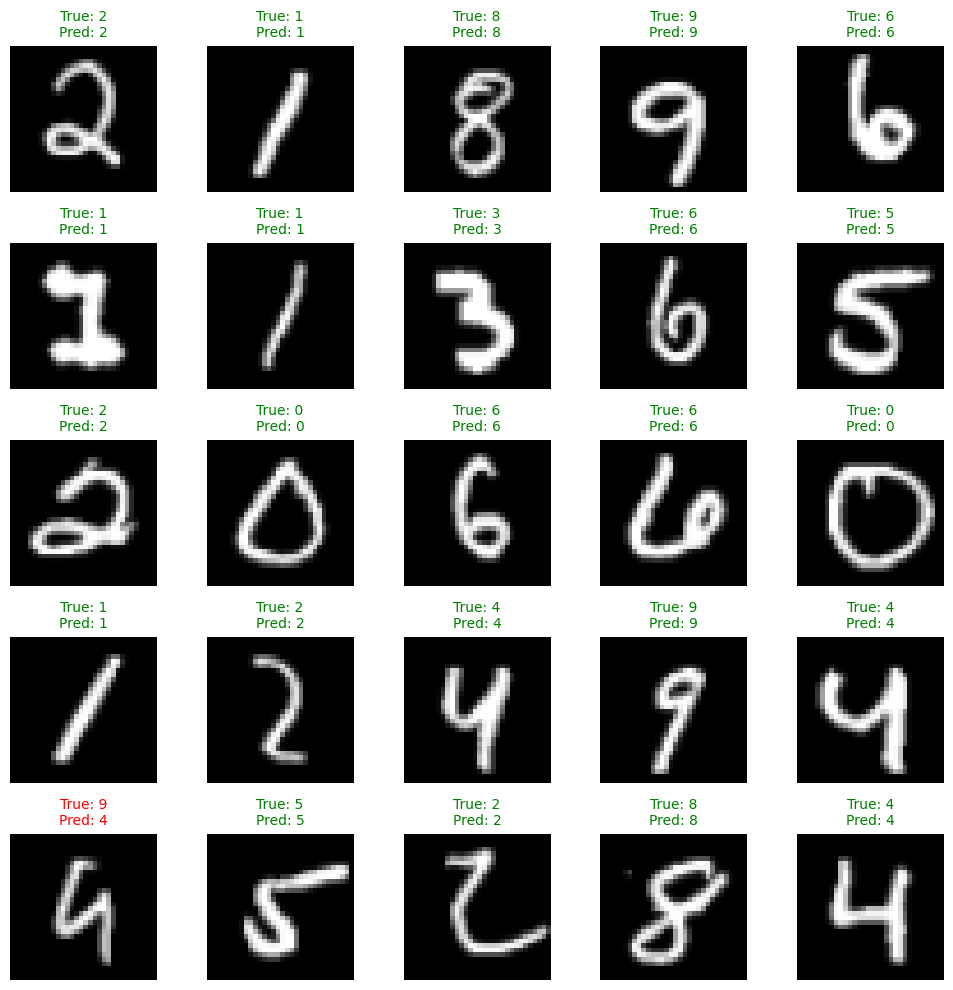

In [ ]:
visualise_predictions(ResNet_model,test_loader,device,num_images=25)

**Confusion Matrix.**

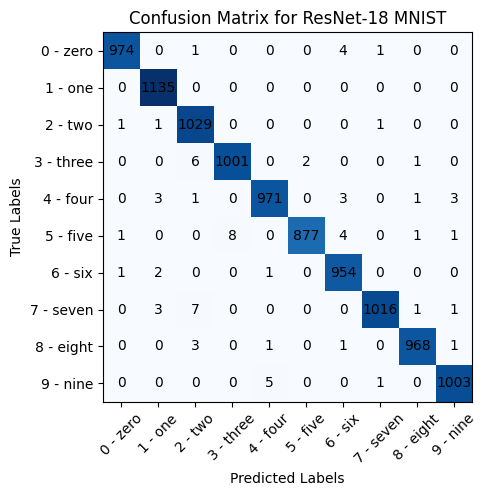

In [ ]:
ResNet_model.to(device).eval()
true_labels =[]
pred_labels =[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =ResNet_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels, pred_labels)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for ResNet-18 MNIST')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report**

In [ ]:
print(f"Classification Report for ResNet-18 MNIST:\n"
      f"{metrics.classification_report(true_labels,pred_labels,target_names=names,digits=4)}\n")

Classification Report for ResNet-18 MNIST:
              precision    recall  f1-score   support

    0 - zero     0.9969    0.9939    0.9954       980
     1 - one     0.9921    1.0000    0.9961      1135
     2 - two     0.9828    0.9971    0.9899      1032
   3 - three     0.9921    0.9911    0.9916      1010
    4 - four     0.9928    0.9888    0.9908       982
    5 - five     0.9977    0.9832    0.9904       892
     6 - six     0.9876    0.9958    0.9917       958
   7 - seven     0.9971    0.9883    0.9927      1028
   8 - eight     0.9959    0.9938    0.9949       974
    9 - nine     0.9941    0.9941    0.9941      1009

    accuracy                         0.9928     10000
   macro avg     0.9929    0.9926    0.9927     10000
weighted avg     0.9928    0.9928    0.9928     10000




**Save the Model**

In [ ]:
model_dir ='/content/models_MNIST'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_MNIST' created at {model_dir}")
else:
    print(f"Directory 'models_MNIST' already exists at {model_dir}")
model_filename =f"{ResNet_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir,model_filename)
torch.save(ResNet_model.state_dict(),model_path)
print(f'Model saved to {model_path}')

Directory 'models_MNIST' created at /content/models_MNIST
Model saved to /content/models_MNIST/ResNet.pth


#VGG

**The model is adapted from PyTorch original implementation [link](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)**

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features =nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))
        self.avgpool =nn.AdaptiveAvgPool2d((7,7))
        self.classifier =nn.Sequential(
            nn.Linear(25088,4096),nn.ReLU(inplace=True),
            nn.Linear(4096,4096),nn.ReLU(inplace=True),
            nn.Linear(4096,10))

    def forward(self,x):
        x =self.features(x)
        x =self.avgpool(x)
        x =x.view(x.size(0), -1)
        x =self.classifier(x)
        prob=F.softmax(x,dim=1)
        return x

In [ ]:
VGG_model = VGG().to(device)
batch_size = 32
train_loader, test_loader = data_loaders(train_data,test_data,batch_size)
VGG_criterion = nn.CrossEntropyLoss()
VGG_optimizer = optim.SGD(VGG_model.parameters(),lr=0.01,momentum=0.9)

train_loader length:1875
test_loader length:313


In [ ]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
try:
    output = VGG_model(x)
    print("Output shape:", output.shape)
except Exception as e:
    print("Error:",e)

Output shape: torch.Size([10, 10])


In [ ]:
summary(VGG_model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

Testing: 100%|██████████| 313/313 [00:06<00:00, 52.10it/s]


Epoch 1: Train Loss:0.2079,Train Accuracy:94.41%, Test Loss:0.0436,Test Accuracy:98.91%, Duration:111.47s


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.70it/s]


Epoch 2: Train Loss:0.0584,Train Accuracy:98.60%, Test Loss:0.0300,Test Accuracy:99.28%, Duration:107.54s
Total training time:219.01s


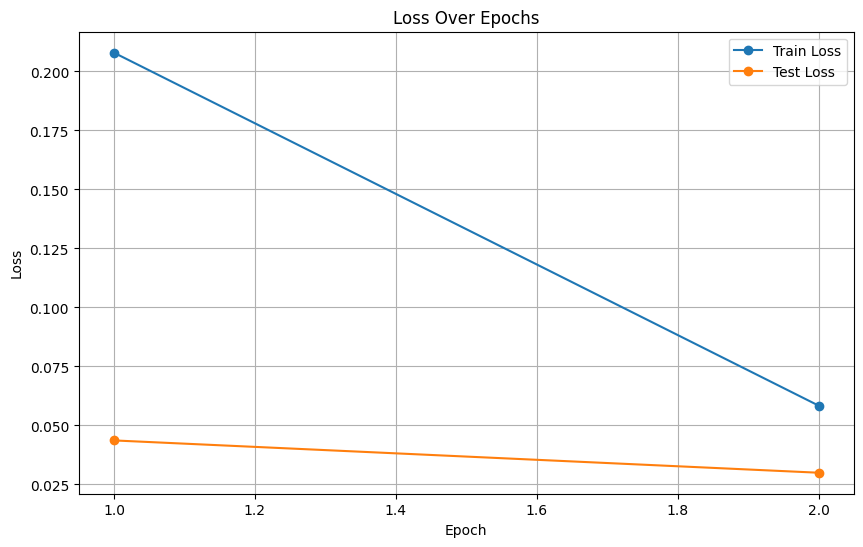

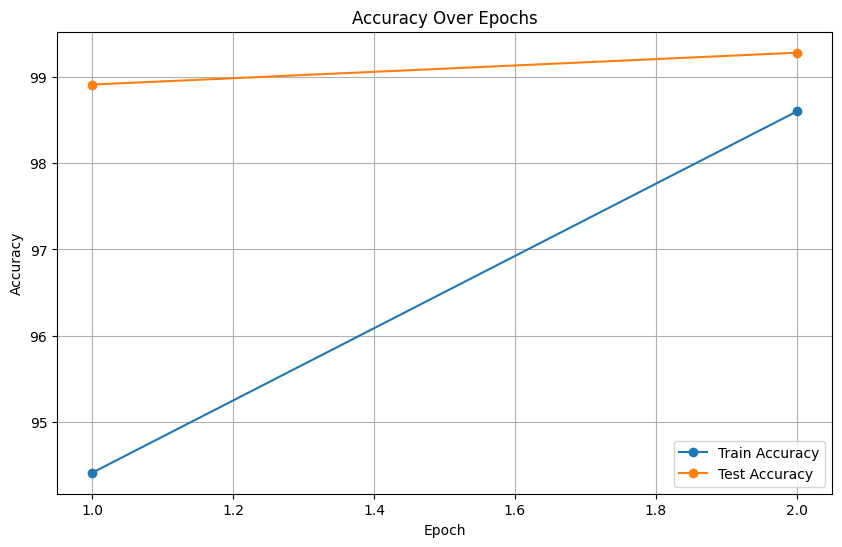

In [ ]:
VGG_train_accuracies,VGG_train_losses,VGG_test_accuracies,VGG_test_losses,VGG_total_train_time =train_and_test(VGG_model, train_loader, test_loader,VGG_criterion,VGG_optimizer,device,num_epochs=2)
plot_loss(VGG_train_losses, VGG_test_losses)
plot_accuracy(VGG_train_accuracies, VGG_test_accuracies)

#**Evaluation**

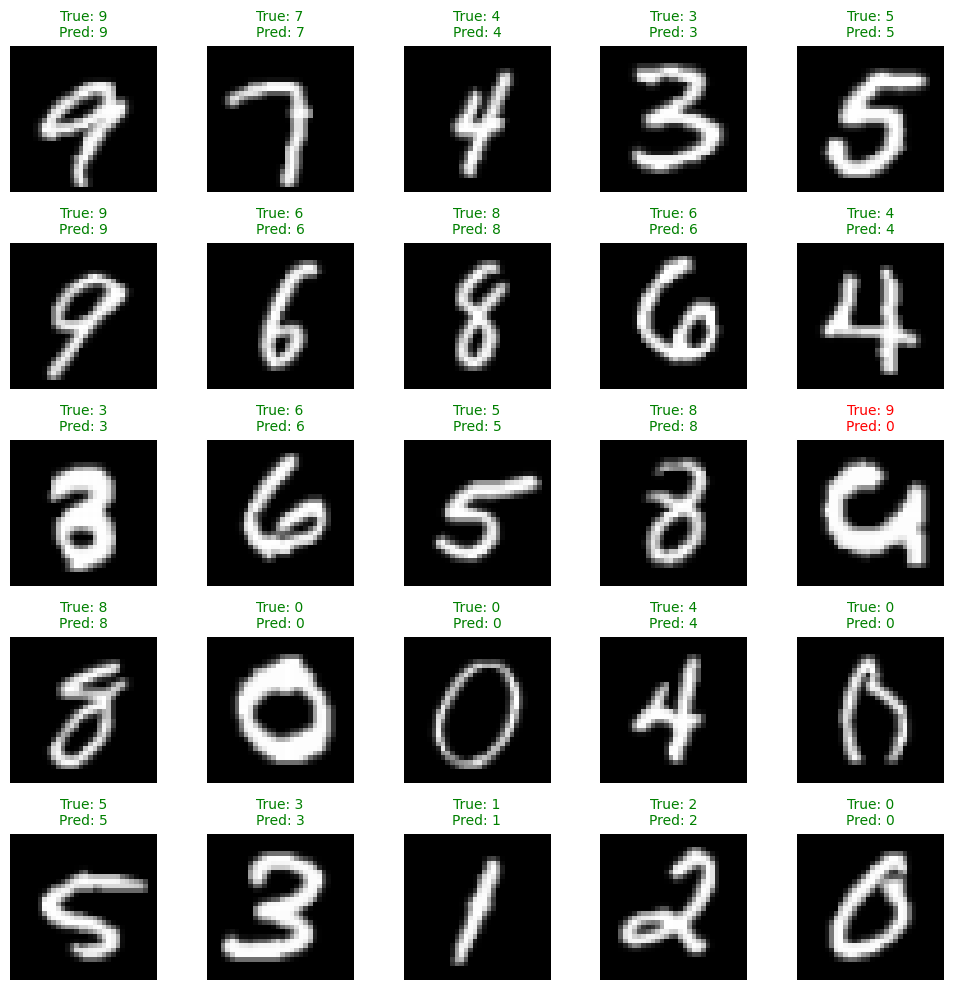

In [ ]:
visualise_predictions(VGG_model,test_loader,device,num_images=25)

**Confussion Matrix**

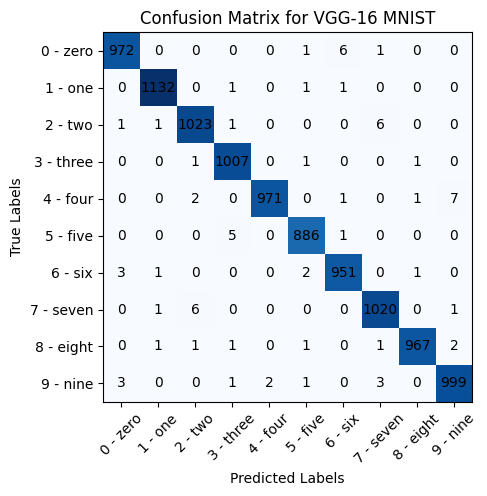

In [ ]:
VGG_model.to(device).eval()
true_labels_v =[]
pred_labels_v =[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =VGG_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels_v.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels_v.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels_v, pred_labels_v)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for VGG-16 MNIST')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report**

In [ ]:
print(f"Classification Report for VGG-16 MNIST:\n"
      f"{metrics.classification_report(true_labels_v,pred_labels_v,target_names=names,digits=4)}\n")

Classification Report for VGG-16 MNIST:
              precision    recall  f1-score   support

    0 - zero     0.9928    0.9918    0.9923       980
     1 - one     0.9965    0.9974    0.9969      1135
     2 - two     0.9903    0.9913    0.9908      1032
   3 - three     0.9911    0.9970    0.9941      1010
    4 - four     0.9979    0.9888    0.9934       982
    5 - five     0.9922    0.9933    0.9927       892
     6 - six     0.9906    0.9927    0.9917       958
   7 - seven     0.9893    0.9922    0.9908      1028
   8 - eight     0.9969    0.9928    0.9949       974
    9 - nine     0.9901    0.9901    0.9901      1009

    accuracy                         0.9928     10000
   macro avg     0.9928    0.9927    0.9928     10000
weighted avg     0.9928    0.9928    0.9928     10000




**Save the Model**

In [ ]:
model_dir ='/content/models_MNIST'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_MNIST' created at {model_dir}")
else:
    print(f"Directory 'models_MNIST' already exists at {model_dir}")
model_filename =f"{VGG_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir,model_filename)
torch.save(VGG_model.state_dict(),model_path)
print(f'Model saved to {model_path}')

Directory 'models_MNIST' already exists at /content/models_MNIST
Model saved to /content/models_MNIST/VGG.pth


#GoogLeNet

**The model is adapted from PyTorch original implementation [link](https://pytorch.org/vision/main/models/generated/torchvision.models.googlenet.html), [source code](https://pytorch.org/vision/main/_modules/torchvision/models/googlenet.html#googlenet)**

In [ ]:
GoogLeNet_model=googlenet(weights=None,aux_logits=False,num_classes=10)
GoogLeNet_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
GoogLeNet_model=GoogLeNet_model.to(device)
batch_size = 32
train_loader, test_loader = data_loaders(train_data,test_data,batch_size)
GoogLeNet_criterion = nn.CrossEntropyLoss()
GoogLeNet_optimizer = optim.SGD(GoogLeNet_model.parameters(),lr=0.01,momentum=0.9)

train_loader length:1875
test_loader length:313


In [ ]:
print(GoogLeNet_model)

GoogLeNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_si

In [ ]:
try:
    output = GoogLeNet_model(x)
    print("Output shape:", output.shape)
except Exception as e:
    print("Error:",e)

Output shape: torch.Size([10, 10])


In [ ]:
summary(GoogLeNet_model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
         MaxPool2d-2             [-1, 64, 8, 8]               0
            Conv2d-3             [-1, 64, 8, 8]           4,096
       BatchNorm2d-4             [-1, 64, 8, 8]             128
       BasicConv2d-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 192, 8, 8]         110,592
       BatchNorm2d-7            [-1, 192, 8, 8]             384
       BasicConv2d-8            [-1, 192, 8, 8]               0
         MaxPool2d-9            [-1, 192, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          12,288
      BatchNorm2d-11             [-1, 64, 4, 4]             128
      BasicConv2d-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 96, 4, 4]          18,432
      BatchNorm2d-14             [-1, 9

**Train**

Testing: 100%|██████████| 313/313 [00:05<00:00, 55.54it/s]


Epoch 1: Train Loss:0.3324,Train Accuracy:90.10%, Test Loss:0.0672,Test Accuracy:97.89%, Duration:75.27s


Testing: 100%|██████████| 313/313 [00:06<00:00, 49.42it/s]


Epoch 2: Train Loss:0.0958,Train Accuracy:97.49%, Test Loss:0.0431,Test Accuracy:98.74%, Duration:76.70s
Total training time:151.98s


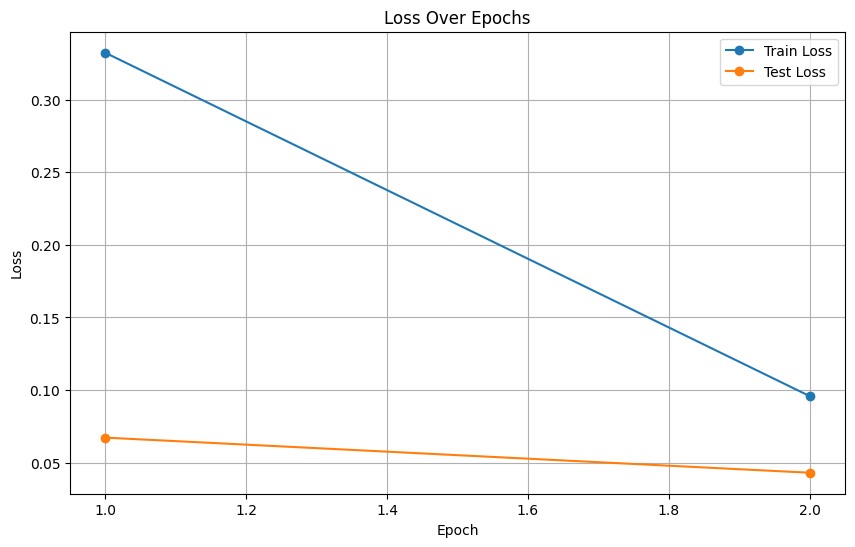

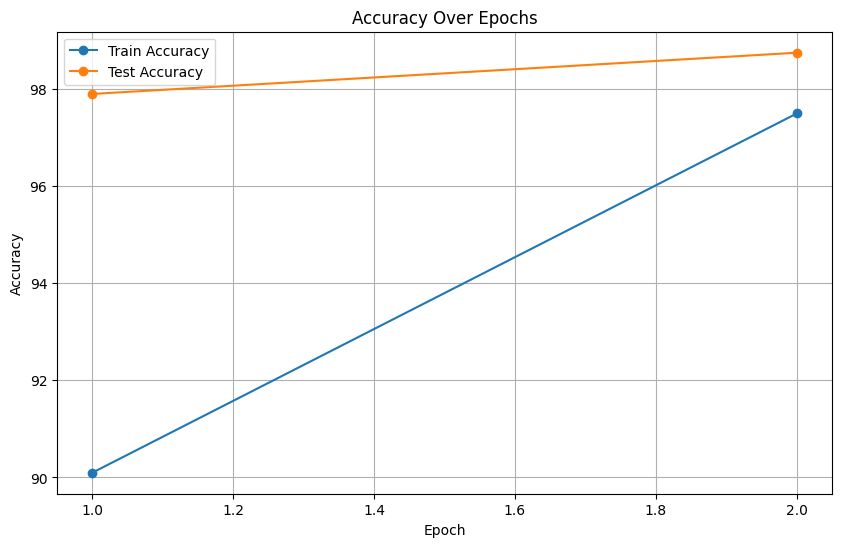

In [ ]:
GoogLeNet_train_accuracies,GoogLeNet_train_losses,GoogLeNet_test_accuracies,GoogLeNet_test_losses,total_train_time =train_and_test(GoogLeNet_model,train_loader,test_loader,GoogLeNet_criterion,GoogLeNet_optimizer,device,num_epochs=2)
plot_loss(GoogLeNet_train_losses,GoogLeNet_test_losses)
plot_accuracy(GoogLeNet_train_accuracies,GoogLeNet_test_accuracies)

#**Evaluation**

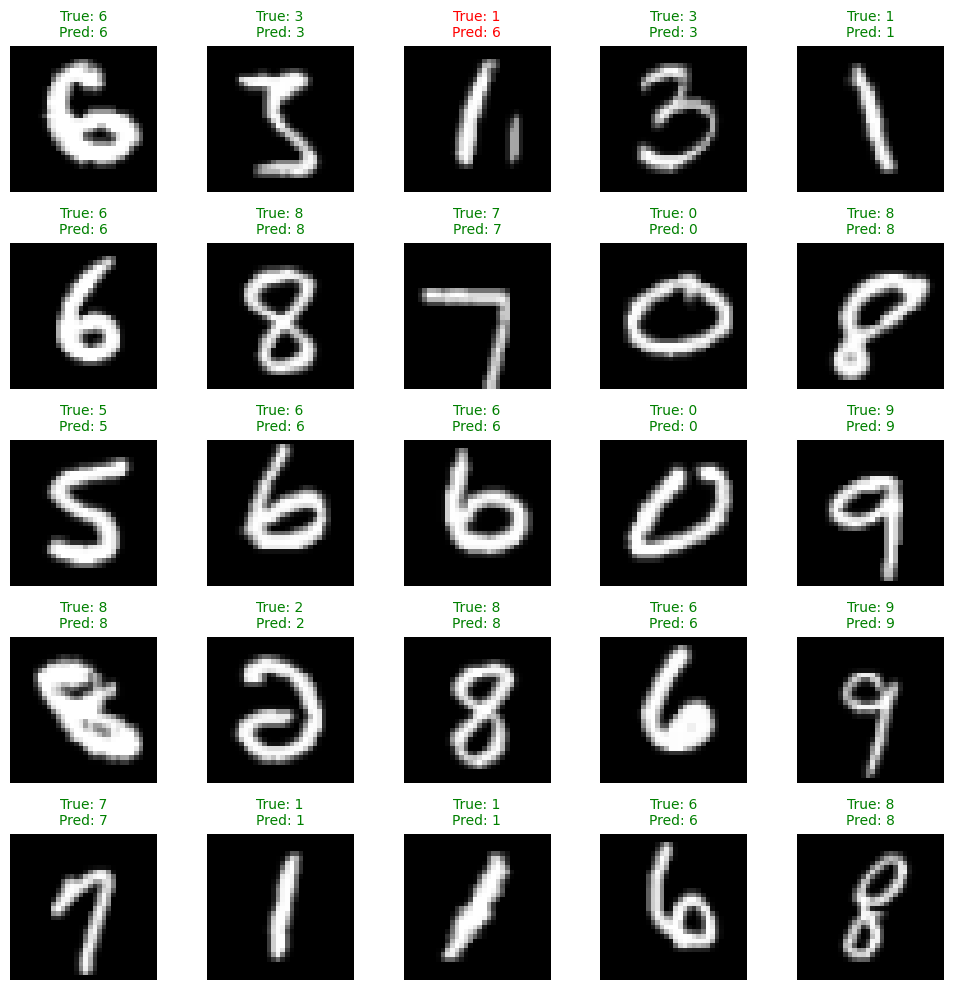

In [ ]:
visualise_predictions(GoogLeNet_model,test_loader,device,num_images=25)

**Confussion Matrix**

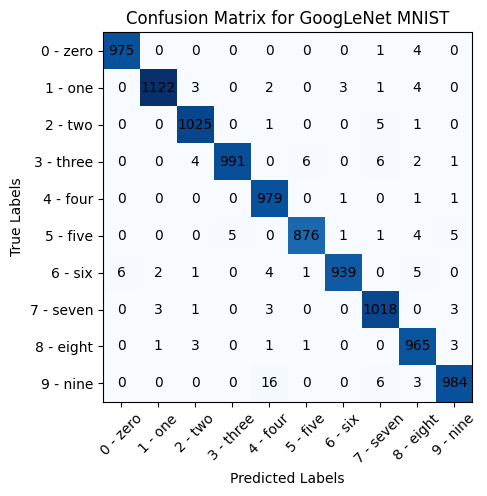

In [ ]:
GoogLeNet_model.to(device).eval()
true_labels_g =[]
pred_labels_g=[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =GoogLeNet_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels_g.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels_g.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels_g, pred_labels_g)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for GoogLeNet MNIST')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report**

In [ ]:
print(f"Classification Report for GoogLeNet MNIST:\n"
      f"{classification_report(true_labels_g,pred_labels_g,target_names=names,digits=4)}\n")

Classification Report for GoogLeNet MNIST:
              precision    recall  f1-score   support

    0 - zero     0.9939    0.9949    0.9944       980
     1 - one     0.9947    0.9885    0.9916      1135
     2 - two     0.9884    0.9932    0.9908      1032
   3 - three     0.9950    0.9812    0.9880      1010
    4 - four     0.9732    0.9969    0.9849       982
    5 - five     0.9910    0.9821    0.9865       892
     6 - six     0.9947    0.9802    0.9874       958
   7 - seven     0.9807    0.9903    0.9855      1028
   8 - eight     0.9757    0.9908    0.9832       974
    9 - nine     0.9870    0.9752    0.9811      1009

    accuracy                         0.9874     10000
   macro avg     0.9874    0.9873    0.9873     10000
weighted avg     0.9875    0.9874    0.9874     10000




**Save the Model**

In [ ]:
model_dir ='/content/models_MNIST'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_MNIST' created at {model_dir}")
else:
    print(f"Directory 'models_MNIST' already exists at {model_dir}")
model_filename =f"{GoogLeNet_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir,model_filename)
torch.save(GoogLeNet_model.state_dict(),model_path)
print(f'Model saved to {model_path}')

Directory 'models_MNIST' already exists at /content/models_MNIST
Model saved to /content/models_MNIST/GoogLeNet.pth
